# Recitation 3

In this recitation we'll do some maximum likelihood exercises using the simple probit model. First let's write code to simulate data from this model and calculate the likelihood of the data given a set of parameters.

Recall that the probit model can be written as:

$$ Y_{n} = \mathbf{1}\{X_{n}\beta - \epsilon_{n} \geq 0 \},\ \epsilon\sim \mathcal{N}(0,1) $$

So it will be simple to simulate data from this model. We'll assume that $X_{n} = [1 X_{n,1} X_{n,2}]$ where each $X_{n,j}$ is distributed as a standard normal.

For no good reason other than that we want to explore the issues later on, suppose that the parameters $\beta_{1},\beta_{2},\beta_{3}$ are a function of deeper structural parameters $\gamma$:

$$ \beta_{1} = \exp(\gamma_{1}+\gamma_{2}), \beta_{2} = \gamma_{2}, \beta_{3} = \gamma_{1} $$

So our objective is to simply

In [31]:
using Distributions, ForwardDiff, Optim, Random, LinearAlgebra, Plots

In [32]:
function simulate_probit(β,N)
    F = Normal()
    X = [ones(N) rand(F,N,2)]
    eps = rand(F,N)
    Y = (X * β .- eps) .> 0
    return (Y,X)
end

function log_likelihood(n,Y,X,β,Fϵ)
    @views xb = dot(X[n,:],β)
    if Y[n]==1
        return log(cdf(Fϵ,xb))
    else
        return log(1-cdf(Fϵ,xb))
    end
end

function log_likelihood(Y,X,β)
    ll = 0.
    N = length(Y)
    Fϵ = Normal()
    for n in eachindex(Y)
        ll += log_likelihood(n,Y,X,β,Fϵ)
    end
    return ll / N
end

log_likelihood (generic function with 2 methods)

## A Warning when Using Automatic Differentiation

For simple models you are unlikely to run into this issue, but for more complicated models you need to be careful when pre-allocating arrays in functions that you plan to differentiate "automatically". Here is an example. Suppose we write the following function to get the reduced form coefficients $\beta$ as a function of $\gamma$:

In [33]:
function get_β_stupid(γ)
    β = zeros(3)
    β[1] = exp(γ[1]+γ[2])
    β[2] = γ[2]
    β[3] = γ[1]
    return β
end

get_β_stupid (generic function with 1 method)

Let's see what happens when we try to take the derivative of the log-likelihood with respect to $\gamma$ using this function:

In [34]:
γ = [0.,0.2]
N = 200
β = get_β_stupid(γ)
Y,X = simulate_probit(β,N)

L(γ) = log_likelihood(Y,X,get_β_stupid(γ))
L(γ)


-0.33713288149822374

In [35]:
dL = ForwardDiff.gradient(L,γ)

LoadError: MethodError: no method matching Float64(::ForwardDiff.Dual{ForwardDiff.Tag{typeof(L), Float64}, Float64, 2})
[0mClosest candidates are:
[0m  (::Type{T})(::Real, [91m::RoundingMode[39m) where T<:AbstractFloat at rounding.jl:200
[0m  (::Type{T})(::T) where T<:Number at boot.jl:772
[0m  (::Type{T})([91m::AbstractChar[39m) where T<:Union{AbstractChar, Number} at char.jl:50
[0m  ...

Ok, we get an error! Why? When we pre-allocated the array $\beta$ in the function `get_β_stupid`, using the `zeros` function, this asserts that the vector can only hold `Float64` variables. When `ForwardDiff` attempts to take the derivative, it instead passes arguments that have a special `Dual` type that cannot be converted to a float. Here are two workarounds for this problem:

In [37]:
function get_β_sensible(γ)
    β = zeros(eltype(γ),3) #<- we let the array take the same type as the argument γ
    β[1] = exp(γ[1]+γ[2])
    β[2] = γ[2]
    β[3] = γ[1]
    return β
end

function get_β_also_sensible(γ)
    return [exp(γ[1]+γ[2]) γ[2] γ[1]]
end

L(γ) = log_likelihood(Y,X,get_β_sensible(γ))
L2(γ) = log_likelihood(Y,X,get_β_also_sensible(γ))
[L(γ) L2(γ)]


1×2 Matrix{Float64}:
 -0.337133  -0.337133

In [38]:
[ForwardDiff.gradient(L,γ) ForwardDiff.gradient(L2,γ)]

2×2 Matrix{Float64}:
 0.0175352  0.0175352
 0.024424   0.024424

So now we have something we can pass to the optimizer and there will be no drama when taking derivatives.

In [45]:
N = 2_000
Y,X = simulate_probit(β,N)
r = optimize(x->-log_likelihood(Y,X,get_β_sensible(x)),γ,Newton(),autodiff=:forward,Optim.Options(show_trace=true))
γ_est = r.minimizer
γ_est


Iter     Function value   Gradient norm 
     0     3.436787e-01     1.513857e-02
 * time: 5.0067901611328125e-5
     1     3.435150e-01     1.481243e-04
 * time: 0.0008308887481689453
     2     3.435149e-01     5.684522e-09
 * time: 0.0011279582977294922


2-element Vector{Float64}:
 -0.004991197627244919
  0.22372487257130555

## Estimating standard errors

In class we saw that for maximum likelihood:

$$ \sqrt{N}(\hat{\theta}-\theta_{0}) \rightarrow_{d} \mathcal{N}(0,-\mathbb{E}H(w,\theta_{0})^{-1}) $$

or alternatively:

$$ \sqrt{N}(\hat{\theta}-\theta_{0}) \rightarrow_{d} \mathcal{N}(0,\mathbb{E}[s(w,\theta_{0})s(w,\theta_{0})^{T}]^{-1}) $$

We can calculate standard errors by estimating either term. In the first case we just take the hessian of the average log-likelihood at the estimate. In the second we calculate the sample covariance of the score at the estimate. The law of large numbers guarantees that either approach is consistent.


In [60]:
# using the Hessian
H = ForwardDiff.hessian(x->log_likelihood(Y,X,get_β_sensible(x)),γ_est)
avar_est = -inv(H) 

2×2 Matrix{Float64}:
  1.64561  -1.02332
 -1.02332   2.00287

In [61]:
# using the score

S = hcat((ForwardDiff.gradient(x->log_likelihood(n,Y,X,get_β_sensible(x),Normal()),γ_est) for n in 1:N)...)
avar_est_2 = inv(cov(S'))

2×2 Matrix{Float64}:
  1.64537   -0.964128
 -0.964128   1.89245

Notice that the estimates are close to each other but not identical. They are only exactly equal in the population limit. To get standard errors, we note that $\hat{\theta}$ is going to be approximately normally distributed around $\theta$ with variance equal to the asymptotic variance *divided by $N$*. So for example the standard errors for $\gamma$ are:

In [62]:
se = sqrt.(diag(avar_est / N))

2-element Vector{Float64}:
 0.02868456117694807
 0.03164541875055554

## Monte-Carlo Validation

Let's validate the estimates using a monte-carlo simulation:

In [71]:
function monte_carlo(num_trials,γ,N)
    γ_sim = zeros(2,num_trials)
    for b in axes(γ_sim,2)
        Y,X = simulate_probit(β,N)
        r = optimize(x->-log_likelihood(Y,X,get_β_sensible(x)),γ,Newton(),autodiff=:forward)
        γ_sim[:,b] = r.minimizer
    end
    return γ_sim
end
γ_sim = monte_carlo(200,γ,N)
var_sim = cov(γ_sim')
se_sim = sqrt.(diag(var_sim))

2-element Vector{Float64}:
 0.02941598344758601
 0.03372272126529965

## Additional Exercises

Some questions for you to ponder.

### Exercise 1 
Suppose you estimate the $\beta$ parameters directly. It would be simple enough to do here. How you could you then back out estimates of $\gamma$ that would give you the same asymptotic variance as maximum likelihood? We will see how to do this when we study **Optimal Minimum Distance**

### Exercise 2 
Suppose we keep the same data-generating process, but that we **misspecify** the model as:
$$ \beta = [\gamma_{1}+\gamma_{2},\ \gamma_{1},\ \gamma_{2}] $$ 
The monte-carlo simulation below shows that the estimates of this misspecified model are still approximately normal. Which assumption is now violated and what formula for the asymptotic variance should we use instead?

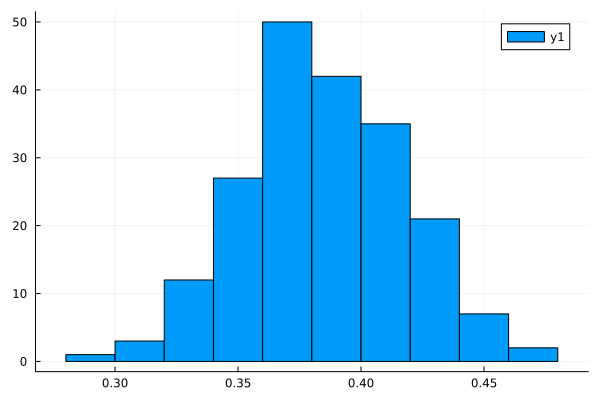

In [76]:
get_β_misspecified(γ) = [γ[1]+γ[2],γ[2],γ[1]]

function monte_carlo_misspecified(num_trials,γ,N)
    γ_sim = zeros(2,num_trials)
    for b in axes(γ_sim,2)
        Y,X = simulate_probit(β,N)
        r = optimize(x->-log_likelihood(Y,X,get_β_misspecified(x)),γ,Newton(),autodiff=:forward)
        γ_sim[:,b] = r.minimizer
    end
    return γ_sim
end
γ_sim = monte_carlo_misspecified(200,γ,N)
histogram(γ_sim[1,:])